# FX Leverage Carry-Trade

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import carry_trade as ct

matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )

## 1. Load data

In [2]:
FX_IR_FR = pd.read_pickle('FX_IR_FR.csv')

In [3]:
# Sort values by day with ascending order 
FX_IR_FR = FX_IR_FR.sort_values(by='Date', ascending=True)

# Set date as index
FX_IR_FR = FX_IR_FR.set_index('Date')

In [4]:
FX_IR_FR

,Currency,SpotRate,1MF,2MF,3MF,6MF,12MF,1MUSD,2MUSD,3MUSD,...,2MJPY,3MJPY,6MJPY,12MJPY,SpotDate,1MFR,2MFR,3MFR,6MFR,12MFR
Date,,,,,,,,,,,,,,,,,,,,,
2009-10-01,USD/JPY,89.930,89.9133,89.8976,89.8752,89.8130,89.4750,0.24563,0.25313,0.28438,...,0.25500,0.34625,0.54625,0.79000,2009-10-06,89.9133,89.8976,89.8752,89.8130,89.4750
2009-10-05,USD/JPY,89.860,89.8448,89.8295,89.8085,89.7450,89.4311,0.24438,0.25313,0.28406,...,0.25125,0.34375,0.54000,0.77875,2009-10-07,89.8448,89.8295,89.8085,89.7450,89.4311
2009-10-06,USD/JPY,89.140,89.1234,89.1095,89.0883,89.0230,88.7060,0.24438,0.25375,0.28406,...,0.25125,0.34375,0.54000,0.77625,2009-10-08,89.1234,89.1095,89.0883,89.0230,88.7060
2009-10-07,USD/JPY,88.921,88.9036,88.8865,88.8637,88.7940,88.4635,0.24438,0.25375,0.28438,...,0.25125,0.34250,0.54000,0.77625,2009-10-09,88.9036,88.8865,88.8637,88.7940,88.4635
2009-10-08,USD/JPY,88.300,88.2832,88.2650,88.2431,88.1710,87.8558,0.24438,0.25375,0.28438,...,0.25125,0.34125,0.54000,0.77375,2009-10-13,88.2832,88.2650,88.2431,88.1710,87.8558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-25,USD/JPY,108.650,108.4547,108.2672,107.9873,107.4149,106.3300,1.80488,1.88100,1.92813,...,-0.09067,-0.11000,-0.04750,0.03883,2019-10-30,108.4547,108.2672,107.9873,107.4149,106.3300
2019-10-29,USD/JPY,108.910,108.7243,108.5337,108.2351,107.6667,106.5432,1.78588,1.86313,1.92713,...,-0.07717,-0.11667,-0.03533,0.05533,2019-10-31,108.7243,108.5337,108.2351,107.6667,106.5432
2019-10-30,USD/JPY,108.840,108.6449,108.3333,108.1599,107.6053,106.4773,1.78138,1.85900,1.90913,...,-0.09750,-0.11683,-0.04200,0.05000,2019-11-01,108.6449,108.3333,108.1599,107.6053,106.4773


## 2. Implement Strategy 

In [21]:
results_1m = ct.algo_loop( FX_IR_FR, trading_period = 30, leverage = 25.0 )

2019-11-11 20:15:27:139239: Beginning Carry-Trade Strategy run
2019-11-11 20:15:29:867768: Algo run complete.


In [15]:
results_1m.to_csv('results_1m.csv')

In [22]:
results_1m

# ps: the amount of euity we invest doesn't affect the PnL(%)

,Signal,USD_IR,JPY_IR,FX_Rate,Equity,Asset Pos,Unreal_PnL,Real_PnL
Date,,,,,,,,
2009-10-01,-0.000126903,0.0024563,0.00175,89.93,10000,-250000,-0.0152012,0
2009-10-05,-0.000108263,0.0024438,0.0017125,89.86,10000,-250000,-0.0346948,0
2009-10-06,-0.000125344,0.0024438,0.0017125,89.14,10000,-250000,-0.235201,0
2009-10-07,-0.000134804,0.0024438,0.0017125,88.921,10000,-250000,-0.296188,0
2009-10-08,-0.00012834,0.0024438,0.0017,88.3,10000,-250000,-0.469124,0
...,...,...,...,...,...,...,...,...
2019-10-25,-0.000209028,0.0180488,-0.00105,108.65,10000,-250000,-0.378483,-1
2019-10-29,-0.000123484,0.0178588,-0.0011533,108.91,10000,-250000,-0.318477,-1
2019-10-30,-0.000216939,0.0178138,-0.00113,108.84,10000,-250000,-0.334633,-1


## 3. Analysis 

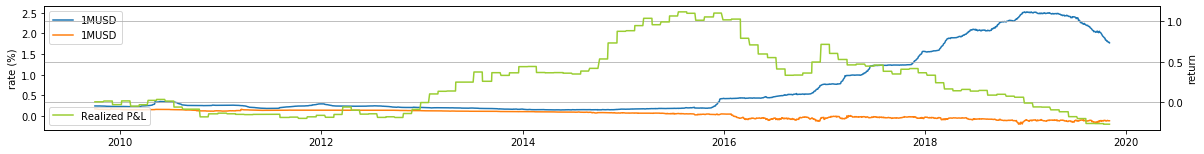

In [21]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax1.grid(False)

ax1.plot(FX_IR_FR.index, FX_IR_FR['1MUSD'], label='1MUSD')
ax1.plot(FX_IR_FR.index, FX_IR_FR['1MJPY'], label='1MUSD')

ax1.legend(loc = 'upper left')
ax1.set_ylabel('rate (%)')

ax2 = ax1.twinx()
ax2.grid(True)

ax2.plot(results_1m.index, results_1m['Real_PnL'], color='yellowgreen', label='Realized P&L')

ax2.legend(loc = 'lower left')
ax2.set_ylabel('return')


plt.savefig('real_PnL.jpg')

